In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import psutil
import os


In [10]:
import pandas as pd

file_path = r'C:\Users\Wilky Martin\Documents\Chaos BPNN\Sorted_Exchange_Rates_CNY_to_IDR.xlsx'
data = pd.read_excel(file_path)
print(data.head(1475))


        NO  Value     Sell      Buy       Date
0     1474      1  2122.75  2101.72 2019-01-02
1     1473      1  2119.45  2098.47 2019-01-03
2     1472      1  2102.76  2081.77 2019-01-04
3     1471      1  2068.98  2048.25 2019-01-07
4     1470      1  2061.49  2041.02 2019-01-08
...    ...    ...      ...      ...        ...
1469     5      1  2240.40  2218.05 2024-12-23
1470     4      1  2224.87  2202.67 2024-12-24
1471     3      1  2231.74  2209.51 2024-12-27
1472     2      1  2237.54  2215.25 2024-12-30
1473     1      1  2225.26  2203.08 2024-12-31

[1474 rows x 5 columns]


In [11]:
df_selected_ = data[['Date', 'Sell']]
# Display the selected data
print(df_selected_.head(1475))

           Date     Sell
0    2019-01-02  2122.75
1    2019-01-03  2119.45
2    2019-01-04  2102.76
3    2019-01-07  2068.98
4    2019-01-08  2061.49
...         ...      ...
1469 2024-12-23  2240.40
1470 2024-12-24  2224.87
1471 2024-12-27  2231.74
1472 2024-12-30  2237.54
1473 2024-12-31  2225.26

[1474 rows x 2 columns]


In [12]:
df_selected_ = df_selected_.copy()

# Normalisasi kolom 'buy'
df_selected_['Sell'] = (df_selected_['Sell'] - df_selected_['Sell'].min()) / (df_selected_['Sell'].max() - df_selected_['Sell'].min())

print(df_selected_.head(1475))

           Date      Sell
0    2019-01-02  0.394741
1    2019-01-03  0.386523
2    2019-01-04  0.344962
3    2019-01-07  0.260845
4    2019-01-08  0.242193
...         ...       ...
1469 2024-12-23  0.687709
1470 2024-12-24  0.649036
1471 2024-12-27  0.666144
1472 2024-12-30  0.680587
1473 2024-12-31  0.650007

[1474 rows x 2 columns]


In [ ]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,Dropout
from tensorflow.keras.optimizers import SGD
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping


def get_cpu_usage():
    usage_percent = psutil.cpu_percent()
    print(f"Current CPU Usage: {usage_percent}%")

s = time.process_time()#start time
# --- Ambil data dan buat window ---
values = df_selected_['Sell'].values
window_size = 3

def create_dataset(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:(i + window_size)])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

# Buat dataset utama dari seluruh data
X_all, y_all = create_dataset(values, window_size)

# Bagi data menjadi train, test, dan val (tanpa shuffle karena time series)
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, train_size=0.7, shuffle=False, random_state=0)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, train_size=0.5, shuffle=False, random_state=0)

# reshape input menjadi [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))


# --- Build LSTM Model ---
model = Sequential()
model.add(LSTM(50, input_shape=(1, window_size),
               kernel_initializer="glorot_uniform",
               bias_initializer="zeros"))
model.add(Dropout(0.2))
model.add(Dense(1))  
# Compile dan train model
opt = SGD(learning_rate=0.01)
model.compile(loss='mean_squared_error', optimizer=opt)

early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

history = model.fit(X_train, y_train,
                    epochs=1000,
                    validation_data=(X_val, y_val),
                    verbose=2,batch_size=None,callbacks=[early_stopping])

e = time.process_time()#end time\
print(f"{e - s} seconds")



# --- Plot Loss ---
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

get_cpu_usage()


Epoch 1/1000


ValueError: Exception encountered when calling LSTMCell.call().

[1mDimensions must be equal, but are 3 and 1 for '{{node sequential_5_1/lstm_5_1/lstm_cell_1/MatMul}} = MatMul[T=DT_FLOAT, grad_a=false, grad_b=false, transpose_a=false, transpose_b=false](sequential_5_1/lstm_5_1/strided_slice_2, sequential_5_1/lstm_5_1/lstm_cell_1/Cast/ReadVariableOp)' with input shapes: [?,3], [1,200].[0m

Arguments received by LSTMCell.call():
  • inputs=tf.Tensor(shape=(None, 3), dtype=float32)
  • states=('tf.Tensor(shape=(None, 50), dtype=float32)', 'tf.Tensor(shape=(None, 50), dtype=float32)')
  • training=True

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Test Loss: 0.00050


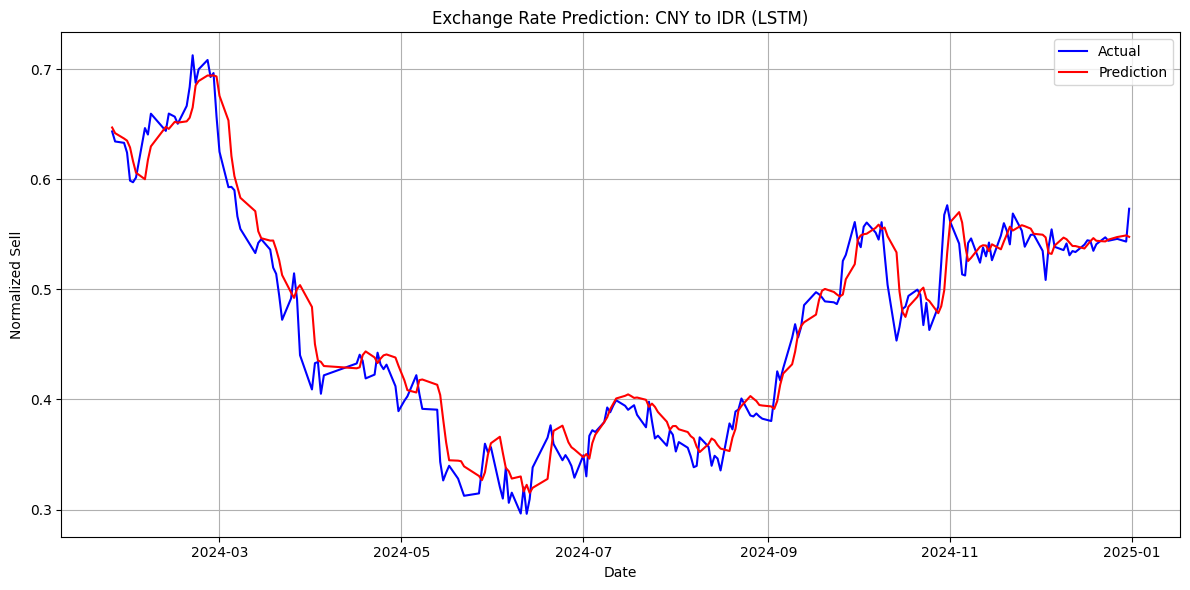

In [14]:
# Prediksi pada data uji
y_pred = model.predict(X_test)

# Hitung loss
test_loss = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.5f}")

# Ambil tanggal sesuai panjang data test
date_test = df_selected_['Date'][-len(y_test):].reset_index(drop=True)

# Konversi y_pred ke 1D array agar bisa diplot
y_pred = y_pred.flatten()

plt.figure(figsize=(12, 6))
plt.plot(date_test, y_test, label="Actual", color="blue")
plt.plot(date_test, y_pred, label="Prediction", color="red")
plt.xlabel("Date")
plt.ylabel("Normalized Sell")
plt.title("Exchange Rate Prediction: CNY to IDR (LSTM)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


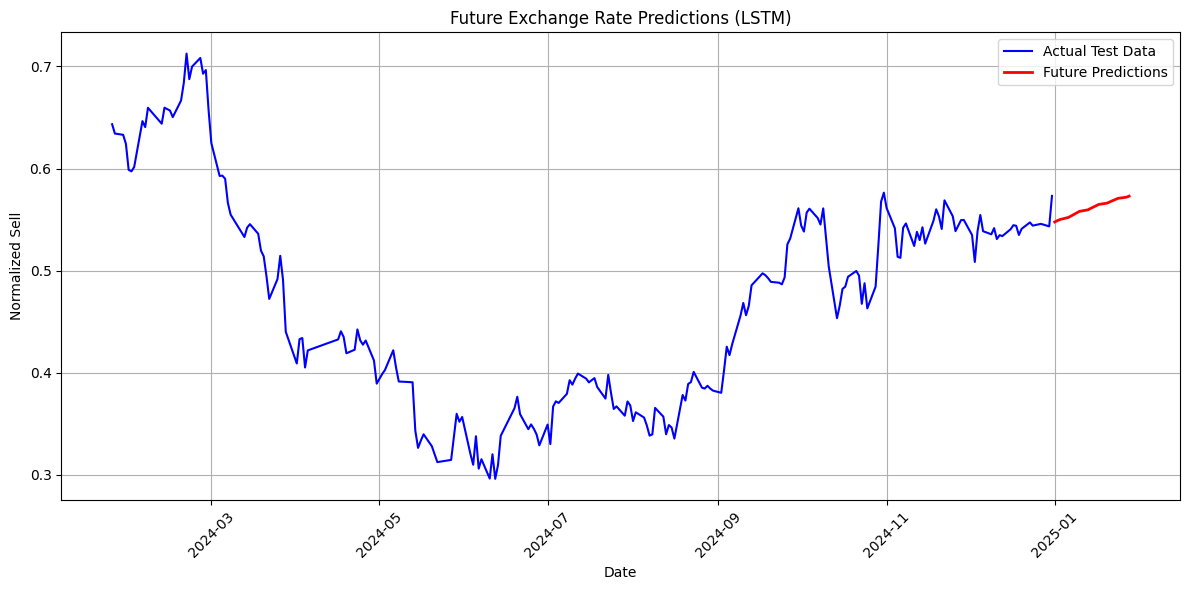

In [15]:
# Jumlah langkah prediksi ke depan
n = 20  # Anda dapat memodifikasi nilai ini

# Data terakhir dari testing
# Input terakhir dari X_test untuk memulai prediksi
last_input = X_test[-1].reshape(1, 1, window_size)

# Melakukan prediksi sebanyak n langkah ke depan
future_predictions = []
for _ in range(n):
    pred = model.predict(last_input, verbose=0)
    future_predictions.append(pred[0, 0])
    # Update input dengan menggeser data dan menambahkan prediksi terbaru
    last_input = np.roll(last_input, -1, axis=2)
    last_input[0, 0 ,-1] = pred[0, 0]

# Ambil tanggal terakhir dari dataset dan buat tanggal masa depan
last_date = df_selected_['Date'].iloc[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=n, freq='B')  # hanya hari kerja

# Plot hasil prediksi dengan tanggal nyata
plt.figure(figsize=(12, 6))
plt.plot(df_selected_['Date'][-len(y_test):], y_test, label="Actual Test Data", color='blue')
plt.plot(future_dates, future_predictions, label='Future Predictions', color='red', linewidth=2)
plt.xlabel('Date')
plt.ylabel('Normalized Sell')
plt.title('Future Exchange Rate Predictions (LSTM)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()